# Imports & Configuration

In [1]:
import os
import json
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
from typing import Union, List, Literal
from tsforecast import TSModel, Preprocessing
from sklearn.metrics import mean_squared_error
%matplotlib inline


logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s:%(message)s")
LOGGER = logging.getLogger(__name__)

# Read input data

In [2]:
metric_list = ["317694", "317709", "317711", "317768", "389614"]
data = pd.read_csv("../../.data/метрики_торгового_эквайринга.csv", usecols=["datetime", *metric_list], parse_dates=["datetime"])

print(data.shape)
display(data.head())

(1725120, 6)


,datetime,317694,317709,317711,317768,389614
0,2020-01-01 00:00:00,0.0,0.0,0.0,2.0,NaN
1,2020-01-01 00:01:00,0.0,0.0,0.0,1.0,NaN
2,2020-01-01 00:02:00,0.0,0.0,0.0,0.0,NaN
3,2020-01-01 00:03:00,0.0,0.0,0.0,1.0,NaN
4,2020-01-01 00:04:00,0.0,0.0,0.0,4.0,NaN


In [3]:
data.dtypes

datetime    datetime64[ns]
317694             float64
317709             float64
317711             float64
317768             float64
389614             float64
dtype: object

# Evaluation

In [4]:
def forecast(data: pd.DataFrame, model_params: dict = {}, roles: dict = {}, train_size: int = 28, horizon: int = 1, step: int = 1, 
             stages: List[Literal["extend_time", "interpolate"]] = ["extend_time", "interpolate"], logs: str = "./logs.txt", 
             forecast_path: str = "./forecast.csv") -> None:
    datetime_col = roles.get("datetime") if (isinstance(roles, dict) and roles.get("datetime")) else "datetime"
    datetime_min, datetime_max = data[datetime_col].agg(["min", "max"])
    LOGGER.debug("Datetime\tfrom %s to %s" % (datetime_min, datetime_max))

    pp = Preprocessing(roles=roles, stages=stages)

    if not os.path.exists(forecast_path):
        with open(forecast_path, "w") as f:
            f.write("metric_id,datetime,forecast,trend,seasonal\n")

    if not os.path.exists(logs):
        with open(logs, "w") as f:
            f.write("metric_id,train_start,train_end,pred_start,pred_end,inference_time,mse\n")

    pred_start = datetime_min.normalize() + pd.Timedelta(days=train_size)
    LOGGER.debug("Iterate over dates")
    while pred_start + pd.Timedelta(days=horizon, minutes=-1) < datetime_max:
        train_start, train_end = pred_start - pd.Timedelta(days=train_size), pred_start - pd.Timedelta(minutes=1)
        pred_end = pred_start + pd.Timedelta(days=horizon, minutes=-1)
        LOGGER.debug("Train\tfrom %s to %s" % (train_start, train_end))
        LOGGER.debug("Prediction\tfrom %s to %s" % (pred_start, pred_end))

        trainset = data[(data[datetime_col] >= train_start) & (data[datetime_col] <= train_end)]
        testset = data[(data[datetime_col] >= pred_start) & (data[datetime_col] <= pred_end)]
        LOGGER.debug("Train size:\t%s" % len(trainset))
        LOGGER.debug("Test size:\t\t%s" % len(testset))

        LOGGER.debug("Train data preprocessing")
        trainset = pp(trainset)

        LOGGER.debug("Forecasting")
        model = TSModel(**model_params)
        try:
            start = time.time()
            forecast, trend, seasonal = model.fit_predict(data=trainset, horizon=horizon)
            end = time.time()
            timeline = pd.date_range(start=pred_start, end=pred_end, freq="1T")
            forecast = pd.DataFrame(data={
                "metric_id": roles.get("value"),
                "datetime": timeline, 
                "forecast": forecast, 
                "trend":    trend, 
                "seasonal": seasonal})
            LOGGER.debug("Forecast size:\t%s" % len(forecast))

            forecast.to_csv(forecast_path, mode="a", index=False, header=False)
            LOGGER.debug("Forecast saved")

            LOGGER.debug("MSE calculation:\t%s" % len(forecast))
            testset = testset.merge(forecast[["datetime", "forecast"]], how="left", on="datetime")
            testset = testset.dropna(axis=0, how="any")
            if not testset.empty:
                mse = mean_squared_error(testset[roles.get("value")].values, testset["forecast"])
            else:
                mse = ""

            with open(logs, "a") as f:
                f.write("%s,%s,%s,%s,%s,%s,%s\n" % (roles.get("value"), train_start, train_end, pred_start, pred_end, end - start, mse))
                LOGGER.debug("Logs saved")

        except ValueError:
            with open(logs, "a") as f:
                f.write("%s,%s,%s,%s,%s,%s,%s\n" % (roles.get("value"), train_start, train_end, pred_start, pred_end, "", ""))
                LOGGER.debug("Logs saved")

        pred_start += pd.Timedelta(days=step)
    return


In [27]:
logs = "./logs.txt"
forecast_path = "./forecast.csv"
holidays = pd.read_excel("./holidays.xlsx", parse_dates=[0]).rename(columns={"Дата": "datetime"})

if os.path.exists(logs):
    os.remove(logs)
if os.path.exists(forecast_path):
    os.remove(forecast_path)

for metric_id in data.columns.drop("datetime"):
    roles = {"value": metric_id}
    model_params = dict(
        h_size=28, 
        trend="linear",
        roles=roles,
        seasonal_type="weekly",
        agg_f="median",
        model_type="multiplicative",
        holidays=None,
    )
    forecast(data=data.loc[:, ["datetime", metric_id]], model_params=model_params, roles=roles, horizon=1, step=1, logs=logs, forecast_path=forecast_path)

c:\Users\alpex\HSE_study\Git\ds\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\alpex\HSE_study\Git\ds\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\alpex\HSE_study\Git\ds\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\alpex\HSE_study\Git\ds\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\alpex\HSE_study\Git\ds\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis,

# Results visualization

## Read logs / forecast

In [28]:
log_results = pd.read_csv("./logs.txt", parse_dates=[1, 2, 3, 4])

print(log_results.shape)
display(log_results.head())

(5845, 7)


,metric_id,train_start,train_end,pred_start,pred_end,inference_time,mse
0,317694,2020-01-01,2020-01-28 23:59:00,2020-01-29,2020-01-29 23:59:00,0.012002,15313.879237
1,317694,2020-01-02,2020-01-29 23:59:00,2020-01-30,2020-01-30 23:59:00,0.009999,14018.321587
2,317694,2020-01-03,2020-01-30 23:59:00,2020-01-31,2020-01-31 23:59:00,0.014959,18597.550030
3,317694,2020-01-04,2020-01-31 23:59:00,2020-02-01,2020-02-01 23:59:00,0.010998,18577.551573
4,317694,2020-01-05,2020-02-01 23:59:00,2020-02-02,2020-02-02 23:59:00,0.010999,20705.034163


In [29]:
# read holidays
holidays = pd.read_excel("./holidays.xlsx", parse_dates=[0])
holidays.head()

,Дата,Выходной / праздник,Предпраздничный / сокращенный,Перенос праздничного дня с выходного,Внеочередной рабочий день
0,2020-01-01,Новогодние каникулы,NaN,NaN,NaN
1,2020-01-02,Новогодние каникулы,NaN,NaN,NaN
2,2020-01-03,Новогодние каникулы,NaN,NaN,NaN
3,2020-01-04,Новогодние каникулы,NaN,NaN,NaN
4,2020-01-05,Новогодние каникулы,NaN,NaN,NaN


C:\Users\alpex\AppData\Local\Temp\ipykernel_37352\3486059193.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


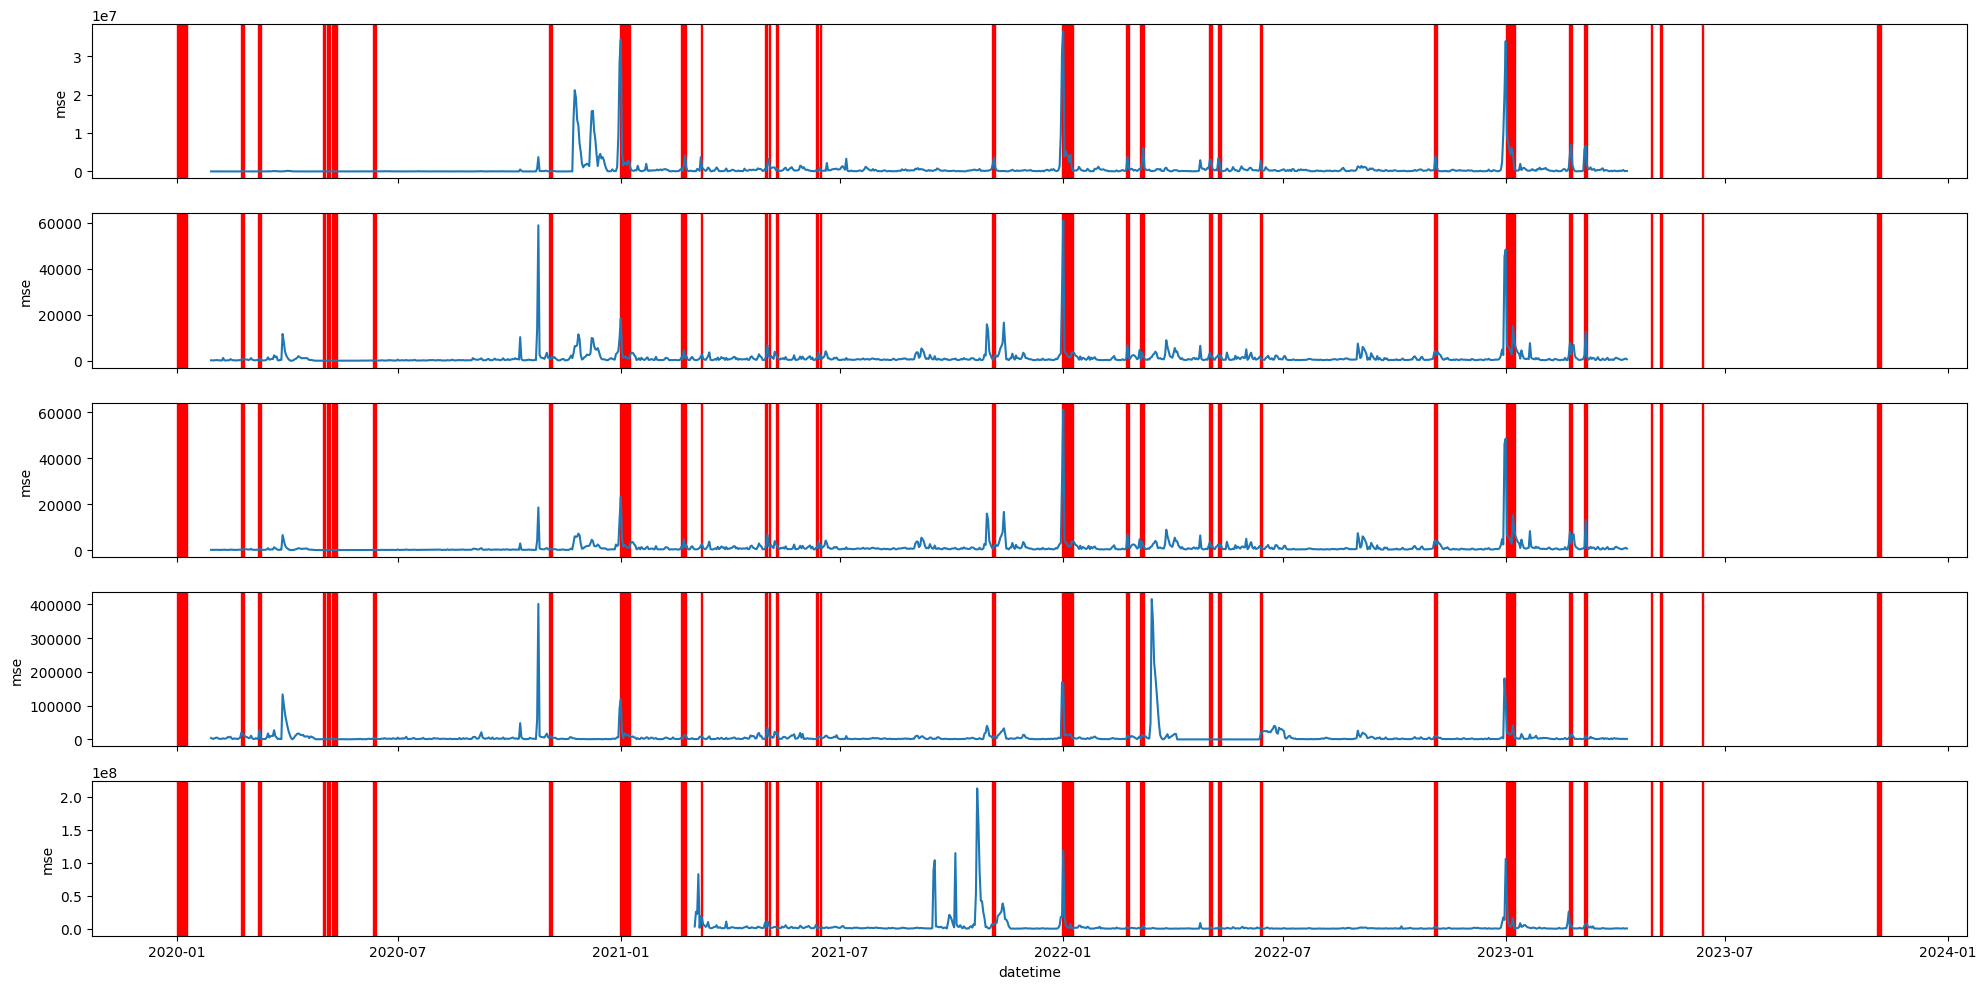

In [30]:
groups = log_results.groupby(by="metric_id")
n_groups = len(groups)
fig, ax = plt.subplots(nrows=n_groups, figsize=(20, 2*n_groups), sharex=True)
for idx, (metric_id, metric_logs) in enumerate(groups):
    sns.lineplot(data=metric_logs, x="pred_start", y="mse", ax=ax[idx])
    ax[idx].set_xlabel("datetime")

    for _, row in holidays.iterrows():
        date_from, date_to = row["Дата"], row["Дата"] + pd.Timedelta(days=1)
        ax[idx].axvspan(xmin=pd.Timestamp(date_from), 
                        xmax=pd.Timestamp(date_to), color="red")
fig.tight_layout()
fig.show();

In [31]:
log_results.groupby(by="metric_id")["mse"].mean()

metric_id
317694    7.231651e+05
317709    1.406931e+03
317711    1.242223e+03
317768    6.813832e+03
389614    3.434195e+06
Name: mse, dtype: float64

In [32]:
log_results[~log_results["pred_start"].isin(holidays["Дата"])].groupby(by="metric_id")["mse"].mean()

metric_id
317694    4.718381e+05
317709    1.188444e+03
317711    1.007076e+03
317768    6.068664e+03
389614    2.964737e+06
Name: mse, dtype: float64

# Stat test

In [23]:
# load forecast
forecast = pd.read_csv("./forecast.csv", parse_dates=[1])
metric_list = forecast["metric_id"].unique().tolist()

# load and prepare historical data
historical_data = pd.read_csv("../../.data/метрики_торгового_эквайринга.csv", usecols=["datetime", *map(str, metric_list)], parse_dates=["datetime"])
historical_data = historical_data.melt(id_vars=["datetime"], var_name="metric_id", value_name="actual_value")
historical_data["metric_id"] = historical_data["metric_id"].astype("int64")

# join results and limit datetime from 2021-01-01 00:00:00 to 2022-12-31 23:59:00
join_data = forecast.merge(historical_data, how="inner", on=["metric_id", "datetime"])
join_data = join_data[(join_data["datetime"] >= "2021-01-01 00:00:00") & (join_data["datetime"] <= "2022-12-31 23:59:00")].reset_index(drop=True)

print(join_data.shape)
display(join_data.head(2))

(5135040, 6)


,metric_id,datetime,forecast,trend,seasonal,actual_value
0,317694,2021-01-01 00:00:00,151.175052,6916.419160,0.021857,0.0
1,317694,2021-01-01 00:01:00,83.439863,6916.468924,0.012064,0.0


In [24]:
join_data.groupby(by=["metric_id"])["datetime"].agg(["min", "max"])

,min,max
metric_id,,
317694,2021-01-01,2022-12-31 23:59:00
317709,2021-01-01,2022-12-31 23:59:00
317711,2021-01-01,2022-12-31 23:59:00
317768,2021-01-01,2022-12-31 23:59:00
389614,2021-03-25,2022-12-31 23:59:00


In [28]:
def apply_test(input_data: pd.DataFrame) -> float:
    # prepare test data
    input_data["diff"] = input_data["forecast"] - input_data["actual_value"]
    test_data = input_data.loc[(input_data["datetime"].dt.hour >= 12) & 
                               (input_data["datetime"].dt.hour < 18), "diff"].dropna().values
    
    if len(test_data) == 0:
        return np.nan
    
    # perform the test
    _, p_value = sps.ttest_1samp(a=test_data, popmean=0, alternative="less")
    return p_value


results = \
    join_data.groupby(by=["metric_id", join_data["datetime"].dt.normalize()]) \
             .apply(apply_test) \
             .to_frame("p_values") \
             .reset_index(drop=False)

print(results.shape)
display(results.head(2))

(3566, 3)


,metric_id,datetime,p_values
0,317694,2021-01-01,1.0
1,317694,2021-01-02,1.0


In [30]:
grouped_results = \
    results.groupby(by="metric_id") \
           .apply(lambda group: (group["p_values"] > 0.05).mean())
grouped_results

metric_id
317694    0.849315
317709    0.665753
317711    0.663014
317768    0.602740
389614    0.605263
dtype: float64